In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = 100

In [3]:
train = pd.read_csv('Train.csv')

In [4]:
cancel_rules = train['Cancellation Rules'].unique().tolist()
cancel_map = { s: chr(ord('a')+i)  for (i, s) in enumerate(cancel_rules) }
train['cancel_rule_id'] = train['Cancellation Rules'].map(cancel_map)

In [5]:
def get_stay_length(rec):
    place_list = rec.split(' . ')
    stay_length = sum([int(n[0]) for n in place_list])
    return stay_length
train['stay_length'] = train.Itinerary.apply(get_stay_length)

In [6]:
train['count_sightseeing'] = train['Sightseeing Places Covered'].apply(lambda x: len(x.split('|')))

In [7]:
train['count_places'] = train['Places Covered'].apply(lambda x: len(x.split('|')))

In [8]:
train['travel_month'] = pd.to_datetime(train['Travel Date'], format='%d-%m-%Y').dt.month
train['travel_year'] = pd.to_datetime(train['Travel Date'], format='%d-%m-%Y').dt.year

In [9]:
train['count_airtravel'] = train.Airline.apply(lambda x: len(x.split('|')))

In [10]:
train['dummy'] = 1
airline_list = list(train.groupby('dummy')['Airline'].apply(set).values[0])

airlines = set()
for a in airline_list:
    a1 = set(a.split('|'))
    airlines = airlines.union(a1)

In [11]:
for airline_col in list(airlines):
    train[airline_col] = 0
for i in range(train.shape[0]):
    rec = train.at[i, 'Airline']
    travel_airlines = list(set(rec.split('|')))
    for ta in travel_airlines:
        train.at[i, ta] = 1

In [12]:
X = train.drop(['Uniq Id', 'Package Name', 'Places Covered'], axis=1)

In [13]:
n_map = { '': 0, 'Not Available':9, 'One': 1, 'Two': 2, 'Three': 3, 'Four':4, 'Five':5}

In [14]:
def fix(n):
    n_map = { 'Not Available':0, '': 0, 'One': 1, 'Two': 2, 'Three': 3, 'Four':4, 'Five':5}
    ret_value = n_map.get(n)
    if ret_value is None:
        return float(n)
    else:
        return ret_value

def mean(l):
    nozero = [i for i in l if i!=0 ]
    if len(nozero) == 0:
        return 0
    nozero_mean = sum(nozero)/len(nozero)
    nozero_l = [i if i!= 0 else nozero_mean for i in l ]

    return np.round(sum(nozero_l)/len(nozero_l), 2)

In [15]:
X['mean_hotel_rating'] = X['Hotel Details'].apply(lambda x: x.split('|')).\
                   apply(lambda x: [p.split(':')[-1] for p in x] ).\
                   apply(lambda x: mean([fix(i) for i in x]) )

In [16]:
X['count_hotel'] = X['Hotel Details'].apply(lambda x: len(x.split('|')))

In [17]:
X['destination_first'] = X.Destination.apply(lambda x: x.split('|')[0])
X['destination_last'] = X.Destination.apply(lambda x: x.split('|')[-1])

In [18]:
X_final = X.drop(['Travel Date', 'Destination', 'Itinerary', 'Airline', 
                  'Sightseeing Places Covered', 'Cancellation Rules', 'Hotel Details'], axis=1)

In [19]:
cat_cols = ['Package Type', 'cancel_rule_id', 'destination_first', 'destination_last', 'Start City']
num_cols = set(X_final.columns) - set(cat_cols) - {'Per Person Price', 'logPrice', 'dummy'}

In [20]:
X_final['logPrice'] = np.log(X_final['Per Person Price'])
upPrice = np.quantile(X_final.logPrice, 0.98)
downPrice = np.quantile(X_final.logPrice, 0.02)
X_final.loc[X_final.logPrice>upPrice, 'logPrice'] = upPrice
X_final.loc[X_final.logPrice<downPrice, 'logPrice'] = downPrice

In [21]:
import category_encoders as ce

In [22]:
df = pd.concat([X_final[num_cols], ce.CountEncoder().fit_transform(X_final[cat_cols])], axis=1)
y = X_final.logPrice

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify = df.cancel_rule_id)

In [24]:
for algo in (ExtraTreesRegressor(), RandomForestRegressor(), 
             AdaBoostRegressor(), GradientBoostingRegressor(), CatBoostRegressor(verbose=0)):
    algo.fit(X_train, y_train)
    print (algo.score(X_test, y_test))

0.8655945174680734
0.87983726985872
0.6253964800579538
0.8040618264257801
0.8785263785591156


In [25]:
rf_model = RandomForestRegressor().fit(X_train, y_train)

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

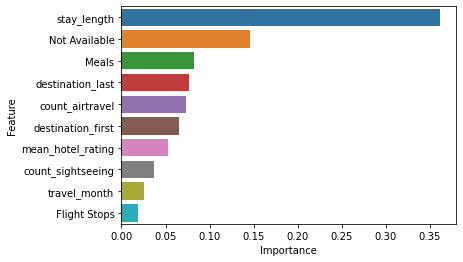

In [26]:
df_importance = pd.DataFrame( rf_model.feature_importances_, columns=['Importance'] )
df_importance['Feature'] = X_train.columns.tolist()
df_importance.sort_values(by='Importance', ascending=False, inplace=True)
sns.barplot(x='Importance', y='Feature', data=df_importance.head(10))

In [27]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(
        np.exp(y_test), 
        np.exp(rf_model.predict(X_test))))

0.17980628756859776

---

In [28]:
df['day_per_location'] = df.count_places / df.stay_length

#df['total_meals'] = df.Meals * df.stay_length

df['houseboat'] = 0
df['by_bus'] = 0
df['self_drive'] = 0
df['drive'] = 0
df['international'] = 0

df.loc[train['Package Name'].str.contains('Houseboat'), 'houseboat'] = 1
df.loc[train['Package Name'].str.contains(' Bus'), 'by_bus'] = 1
df.loc[train['Package Name'].str.contains('Self Drive'), 'self_drive'] = 1
df.loc[train['Package Name'].str.contains('Drive'), 'drive'] = 1

df.loc[train['Package Name'].\
           str.contains('New Zeland|Sri Lanka|Abu Dhabi|Dubai|Copenhagen|Moscow|Singapore|Malaysia|Thailand|Bangkok|Phuket|Bali|Kuala Lumpur'), 
       'international'] = 1


In [29]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify = df.cancel_rule_id)
for algo in (ExtraTreesRegressor(), RandomForestRegressor(), 
             GradientBoostingRegressor(), CatBoostRegressor(verbose=0)):
    algo.fit(X_train, y_train)
    print (np.round(algo.score(X_test, y_test), 2), 
           np.round(np.sqrt(mean_squared_log_error(np.exp(y_test), np.exp(algo.predict(X_test)))), 2))

0.86 0.19
0.88 0.18
0.8 0.23
0.87 0.18


In [30]:
from sklearn.ensemble import VotingRegressor

models = [ ('ext', ExtraTreesRegressor()), ('rf', RandomForestRegressor()), ('grd', GradientBoostingRegressor()),
           ('cat', CatBoostRegressor(verbose=0))]

vot_model = VotingRegressor(models).fit(X_train, y_train)

In [31]:
print (np.round(vot_model.score(X_test, y_test), 2), 
           np.round(np.sqrt(mean_squared_log_error(np.exp(y_test), np.exp(vot_model.predict(X_test)))), 2))

0.87 0.18


In [48]:
extra_info = train['Package Name'] + '. ' + train['Sightseeing Places Covered']

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect_info = vect.fit_transform(extra_info)

In [51]:
df_info = pd.DataFrame(vect_info.todense(), columns = ['info_' + s for s in vect.get_feature_names()])

In [54]:
df_big = pd.concat([df, df_info], axis=1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df_big, y, test_size=0.2, stratify = df.cancel_rule_id)
for algo in (ExtraTreesRegressor(), RandomForestRegressor(), 
             GradientBoostingRegressor(), CatBoostRegressor(verbose=0)):
    algo.fit(X_train, y_train)
    print (np.round(algo.score(X_test, y_test), 2), 
           np.round(np.sqrt(mean_squared_log_error(np.exp(y_test), np.exp(algo.predict(X_test)))), 2))

0.87 0.19
0.89 0.17
0.83 0.22
0.89 0.17
